# K Strategy and Vanilla Model Comparison: Adversarial Robustness and Performance

This notebook visualizes and compares the performance of different K scheduling strategies on MNIST, including the vanilla (non-adversarial) model, using metrics such as clean accuracy, adversarial accuracy (for various k), and mean confidence.

In [5]:
import subprocess
import os

results_path = 'results/adversarial_evaluation.csv'
if not os.path.exists(results_path):
    print("Running experiment script to generate results...")
    subprocess.run(['python', 'run_k_strategy_experiment.py'])
else:
    print("Results already exist. Delete the CSV if you want to rerun the experiment.")


Running experiment script to generate results...

Training with Constant scheduler...
Epoch 1/6 | Train Loss: 0.3950, Train Acc: 88.11%
Epoch 2/6 | Train Loss: 0.1057, Train Acc: 96.79% | Test Loss: 0.0838, Test Acc: 97.24%
Epoch 3/6 | Train Loss: 0.0761, Train Acc: 97.69%
Epoch 4/6 | Train Loss: 0.0613, Train Acc: 98.03% | Test Loss: 0.0501, Test Acc: 98.38%
Epoch 5/6 | Train Loss: 0.0525, Train Acc: 98.36%
Epoch 6/6 | Train Loss: 0.0463, Train Acc: 98.53% | Test Loss: 0.0476, Test Acc: 98.38%

Training with Linear scheduler...
Epoch 1/6 | Train Loss: 0.3709, Train Acc: 88.65%
Epoch 2/6 | Train Loss: 1.0147, Train Acc: 68.06% | Test Loss: 0.0787, Test Acc: 97.47%
Epoch 3/6 | Train Loss: 1.6929, Train Acc: 40.90%
Epoch 4/6 | Train Loss: 1.1113, Train Acc: 61.04% | Test Loss: 0.1144, Test Acc: 96.88%
Epoch 5/6 | Train Loss: 0.7846, Train Acc: 73.53%
Epoch 6/6 | Train Loss: 0.6692, Train Acc: 77.59% | Test Loss: 0.0903, Test Acc: 97.26%

Training with LinearUniformMix scheduler...
Epoch 

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import sys
sys.path.append('..')
import Models
from Attacks import pgd_attack

# Load results
df = pd.read_csv('results/adversarial_evaluation.csv')

# --- Evaluate the vanilla model ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Load vanilla model
vanilla_model = Models.SmallConvNet().to(device)
vanilla_model.load_state_dict(torch.load('../models/small_conv_vanilla.pth', map_location=device))
vanilla_model.eval()
# Load MNIST test set
transform = transforms.ToTensor()
test_dataset = datasets.MNIST(root='../data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
criterion = nn.CrossEntropyLoss()
epsilon = 0.3
k_list = [1,2,4,8,16]
# Clean accuracy
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vanilla_model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
vanilla_clean_acc = 100.0 * correct / total
# Adversarial accuracy for each k
vanilla_results = []
for k in k_list:
    correct_adv = 0
    total_adv = 0
    confidences = []
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        adv_images, _ = pgd_attack(images, labels, vanilla_model, criterion, epsilon, k, device)
        outputs = vanilla_model(adv_images)
        probs = F.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        total_adv += labels.size(0)
        correct_adv += (predicted == labels).sum().item()
        for i in range(labels.size(0)):
            confidences.append(probs[i, predicted[i]].item())
    adv_acc = 100.0 * correct_adv / total_adv
    mean_conf = float(torch.tensor(confidences).mean()) if confidences else 0.0
    vanilla_results.append({
        'strategy': 'Vanilla',
        'k': k,
        'clean_acc': vanilla_clean_acc,
        'adv_acc': adv_acc,
        'mean_confidence': mean_conf
    })
# Add vanilla results to DataFrame
df = pd.concat([df, pd.DataFrame(vanilla_results)], ignore_index=True)
df.to_csv('results/adversarial_evaluation_with_vanilla.csv', index=False)
df.head()

,strategy,k,clean_acc,adv_acc,mean_confidence
0,Constant,1,98.38,1.44,0.840227
1,Constant,2,98.38,0.04,0.928316
2,Constant,4,98.38,0.00,0.965793
3,Constant,8,98.38,0.00,0.977343
4,Constant,16,98.38,0.00,0.981802


## 1. Clean Accuracy per Strategy

Barplot of clean accuracy for each K scheduling strategy, including vanilla.

/tmp/ipykernel_829/3006220193.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=clean_acc_df, x='strategy', y='clean_acc', palette='viridis')


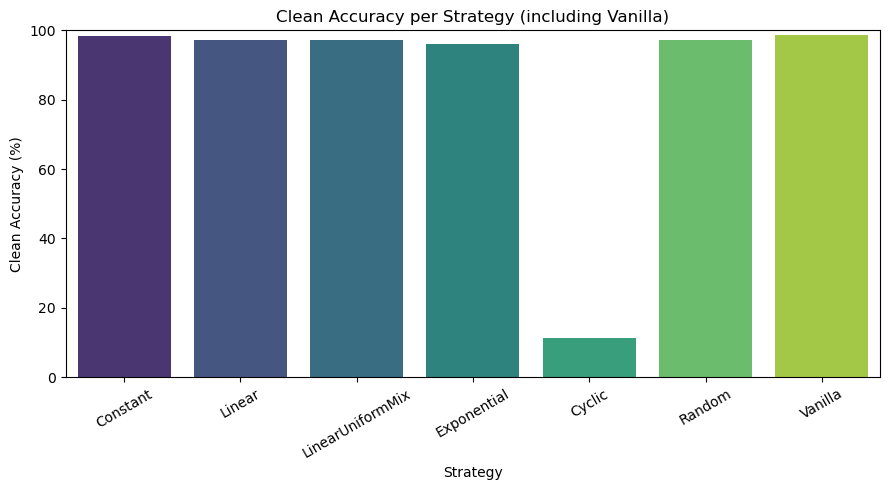

In [7]:
clean_acc_df = df.drop_duplicates(subset=['strategy'])
plt.figure(figsize=(9,5))
sns.barplot(data=clean_acc_df, x='strategy', y='clean_acc', palette='viridis')
plt.title('Clean Accuracy per Strategy (including Vanilla)')
plt.ylabel('Clean Accuracy (%)')
plt.xlabel('Strategy')
plt.ylim(0, 100)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## 2. Adversarial Accuracy vs. k (per Strategy)

Lineplot of adversarial accuracy as a function of attack strength (k) for each strategy, including vanilla.

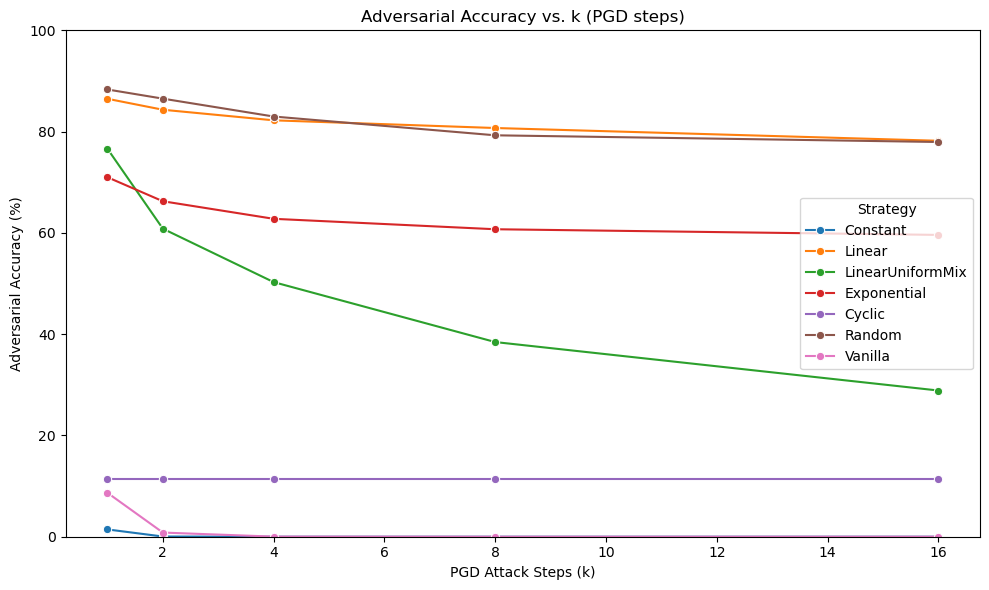

In [8]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x='k', y='adv_acc', hue='strategy', marker='o')
plt.title('Adversarial Accuracy vs. k (PGD steps)')
plt.ylabel('Adversarial Accuracy (%)')
plt.xlabel('PGD Attack Steps (k)')
plt.ylim(0, 100)
plt.legend(title='Strategy')
plt.tight_layout()
plt.show()

## 3. Mean Confidence per Strategy and k

Boxplot of mean confidence for each strategy and attack strength, including vanilla.

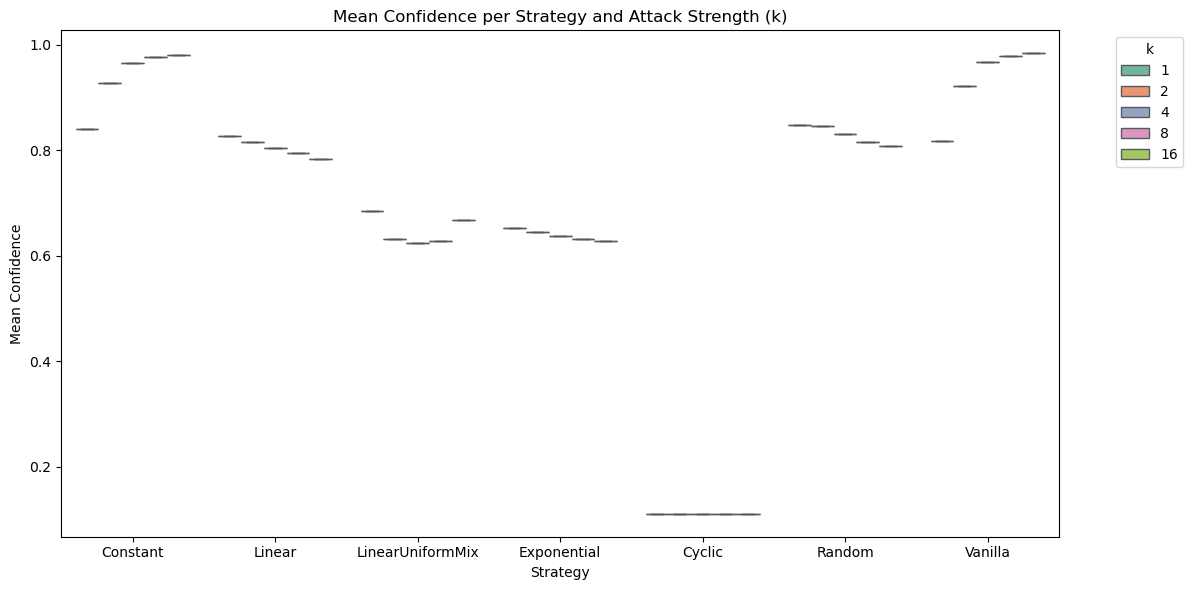

In [9]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='strategy', y='mean_confidence', hue='k', palette='Set2')
plt.title('Mean Confidence per Strategy and Attack Strength (k)')
plt.ylabel('Mean Confidence')
plt.xlabel('Strategy')
plt.legend(title='k', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 4. Summary Table

Table of all metrics for each strategy and k, including vanilla.

In [10]:
df

,strategy,k,clean_acc,adv_acc,mean_confidence
0,Constant,1,98.38,1.44,0.840227
1,Constant,2,98.38,0.04,0.928316
2,Constant,4,98.38,0.00,0.965793
3,Constant,8,98.38,0.00,0.977343
4,Constant,16,98.38,0.00,0.981802
5,Linear,1,97.26,86.48,0.828047
6,Linear,2,97.26,84.32,0.816296
7,Linear,4,97.26,82.23,0.804087
8,Linear,8,97.26,80.71,0.794597
9,Linear,16,97.26,78.19,0.783144


## 5. Vanilla vs. Adversarial Strategies: Robustness and Performance

This section compares the vanilla model to adversarially trained models, highlighting the trade-off between clean accuracy and robustness.

In [12]:
# Find best strategies
best_clean = clean_acc_df.loc[clean_acc_df['clean_acc'].idxmax()]['strategy']
best_adv = df.groupby('strategy')['adv_acc'].mean().idxmax()
most_consistent = df.groupby('strategy')['adv_acc'].std().idxmin()
print(f'Best clean accuracy: {best_clean}')
print(f'Best average adversarial accuracy: {best_adv}')
print(f'Most consistent (lowest std of adv acc): {most_consistent}')

# Print a summary
for strategy in df['strategy'].unique():
    mean_adv = df[df['strategy']==strategy]['adv_acc'].mean()
    std_adv = df[df['strategy']==strategy]['adv_acc'].std()
    print(f'{strategy}: Mean adv acc = {mean_adv:.2f}%, Std = {std_adv:.2f}')

# Vanilla vs. best adversarial
vanilla_mean_adv = df[df['strategy']=='Vanilla']['adv_acc'].mean()
best_adv_mean = df[df['strategy']==best_adv]['adv_acc'].mean()
print(f'Vanilla mean adversarial accuracy: {vanilla_mean_adv:.2f}%')
print(f'Best adversarial strategy mean adversarial accuracy: {best_adv_mean:.2f}%')
print('The vanilla model typically has higher clean accuracy but much lower adversarial robustness. Adversarially trained models trade some clean accuracy for much higher robustness to attacks.')

Best clean accuracy: Vanilla
Best average adversarial accuracy: Random
Most consistent (lowest std of adv acc): Cyclic
Constant: Mean adv acc = 0.30%, Std = 0.64
Linear: Mean adv acc = 82.39%, Std = 3.20
LinearUniformMix: Mean adv acc = 51.01%, Std = 18.71
Exponential: Mean adv acc = 64.07%, Std = 4.62
Cyclic: Mean adv acc = 11.35%, Std = 0.00
Random: Mean adv acc = 83.01%, Std = 4.47
Vanilla: Mean adv acc = 1.90%, Std = 3.80
Vanilla mean adversarial accuracy: 1.90%
Best adversarial strategy mean adversarial accuracy: 83.01%
The vanilla model typically has higher clean accuracy but much lower adversarial robustness. Adversarially trained models trade some clean accuracy for much higher robustness to attacks.
